# AI-Based Trading Strategies

## Attention LSTM Trading Strategy

### Import Libraries & Dependencies

In [1]:
# ================================
# --- Standard Libraries ---
# ================================
import os, shutil, warnings, logging, json
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import pandas as pd

# ================================
# --- Visualization ---
# ================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# ================================
# --- Stats & ML ---
# ================================
# Keep only what we use; prune if unused later.
from scipy.stats import mode  # TODO: remove if unused
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
from sklearn.ensemble import ExtraTreesClassifier  # TODO: remove if unused
from hmmlearn.hmm import GaussianHMM

# ================================
# --- Deep Learning (Attention LSTM) ---
# ================================
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D, Permute, Multiply, Lambda
)
# Legacy Adam for TF 2.10/2.11 compatibility; switch to tf.keras.optimizers.Adam if env permits.
try:
    from tensorflow.keras.optimizers.legacy import Adam
except Exception:
    from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# ================================
# --- Quant & Finance ---
# ================================
# NOTE: quantstats can be heavy/optional; keep import here for now.
import quantstats as qs

# ================================
# --- Utilities / Pretty Printing ---
# ================================

In [2]:
# ================================
# --- Settings ---
# ================================
OUTPUT_DIR = Path("../outputs/04_ATT_LSTM")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'   # suppress TF logs
warnings.filterwarnings("ignore", message=".*HDF5.*legacy.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="quantstats")

In [3]:
# --- Load Local Dataset ---
data_path = Path('../data/GSPC_fixed.csv')
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path.resolve()}")

df = pd.read_csv(
    data_path,
    parse_dates=['Date'],
    index_col='Date'
).sort_index()

df.columns = [col.lower() for col in df.columns]

numeric_cols = ['open', 'high', 'low', 'close', 'adjusted_close', 'volume']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df.ffill(inplace=True)

display(df.head())
display(df.tail())

,open,high,low,close,adjusted_close,volume
Date,,,,,,
2014-01-06,1832.3101,1837.16,1823.7300,1826.77,1826.77,3294850000
2014-01-07,1828.7100,1840.10,1828.7100,1837.88,1837.88,3511750000
2014-01-08,1837.9000,1840.02,1831.4000,1837.49,1837.49,3652140000
2014-01-09,1839.0000,1843.23,1830.3800,1838.13,1838.13,3581150000
2014-01-10,1840.0601,1843.15,1832.4301,1842.37,1842.37,3335710000


,open,high,low,close,adjusted_close,volume
Date,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000


## Data Visualization
- Plot **S&P 500 adjusted closing prices** over time.

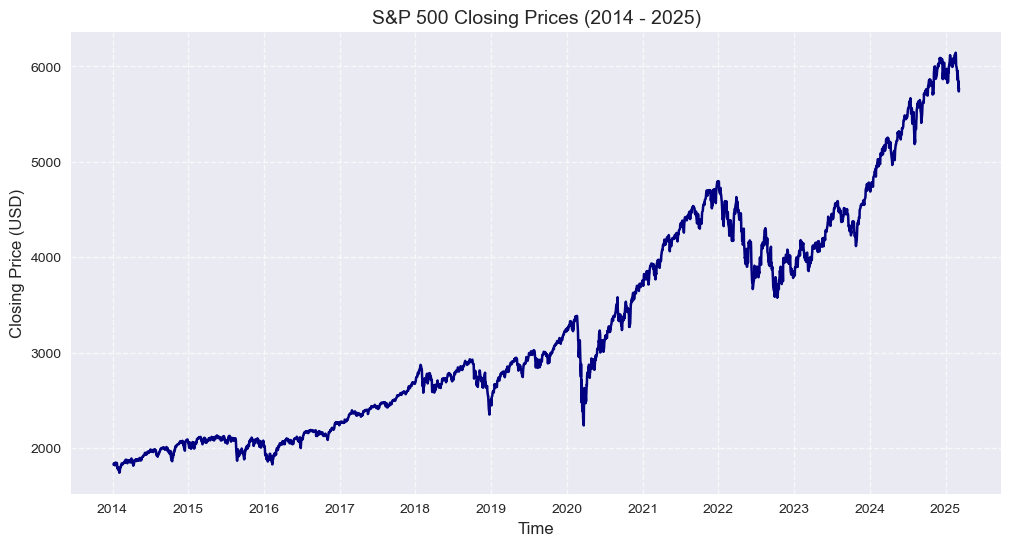

In [4]:
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["adjusted_close"], linewidth=1.8, color='navy')

plt.title("S&P 500 Closing Prices (2014 - 2025)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Closing Price (USD)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  

plt.show()

## Feature Engineering & Transformation

In [5]:
# Compute log returns
df["log_returns"] = np.log(df["adjusted_close"] / df["adjusted_close"].shift(1))

In [6]:
# === Anti-Leakage Utilities (HMM + Scaler) ===
import sys
import contextlib
import io
from dataclasses import dataclass
from typing import Tuple, Dict, Any, Optional
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

@dataclass
class RegimeSpec:
    n_states: int = 3
    covariance_type: str = 'diag'
    n_iter: int = 200
    tol: float = 1e-2
    reg_covar: float = 1e-3
    random_state: int = 42

@contextlib.contextmanager
def _suppress_stderr():
    old_stderr = sys.stderr
    try:
        sys.stderr = io.StringIO()
        yield
    finally:
        sys.stderr = old_stderr

def _fit_hmm_train_only(X_train: np.ndarray, spec: RegimeSpec) -> GaussianHMM:
    hmm = GaussianHMM(
        n_components=spec.n_states,
        covariance_type=spec.covariance_type,
        n_iter=spec.n_iter,
        tol=spec.tol,
        random_state=spec.random_state,
    )
    with _suppress_stderr():
        hmm.fit(X_train)
    return hmm

def fit_transform_regime_features_fold(
    df: pd.DataFrame,
    feature_cols: list,
    train_idx: np.ndarray,
    val_idx: np.ndarray,
    spec: Optional[RegimeSpec] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """Fit HMM on train slice only; transform both train and val to state probabilities.
    Returns (reg_train, reg_val) aligned with train_idx/val_idx order.
    """
    if spec is None:
        spec = RegimeSpec()
    X_train = df.loc[train_idx, feature_cols].values
    X_val   = df.loc[val_idx, feature_cols].values

    hmm = _fit_hmm_train_only(X_train, spec)
    # Use posterior probabilities as regime features (safer than hard states)
    reg_train = hmm.predict_proba(X_train)
    reg_val   = hmm.predict_proba(X_val)
    return reg_train, reg_val

def get_fold_scaler(X_train_2d: np.ndarray) -> StandardScaler:
    scaler = StandardScaler()
    scaler.fit(X_train_2d)
    return scaler

# === Audit helpers ===
def assert_no_future_fit(train_end_ts, val_start_ts):
    assert train_end_ts < val_start_ts, f"Train end {train_end_ts} must be < Val start {val_start_ts}"

def assert_scaler_fit_size(scaler: StandardScaler, expected_n_samples: int):
    # sklearn doesn't expose fit size directly; we'll pass expected_n_samples as a check via logs.
    pass  # placeholder for consistent API; we'll log counts in the CV loop.


### Volatility-Adjusted Returns:

In [7]:
# Rolling Volatility (10-day)
df["volatility_10"] = df["log_returns"].rolling(10).std()

# Volatility-Adjusted Returns
df["vol_adj_returns"] = df["log_returns"] / df["volatility_10"]

df.dropna(inplace=True)
df.head()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns
Date,,,,,,,,,
2014-01-21,1841.05,1849.3101,1832.3800,1843.8000,1843.8000,3782470000,0.002770,0.006332,0.437438
2014-01-22,1844.71,1846.8700,1840.8800,1844.8600,1844.8600,3374170000,0.000575,0.006070,0.094687
2014-01-23,1842.29,1842.2900,1820.0601,1828.4600,1828.4600,3972250000,-0.008929,0.006752,-1.322501
2014-01-24,1826.96,1826.9600,1790.2900,1790.2900,1790.2900,4618450000,-0.021096,0.009358,-2.254436
2014-01-27,1791.03,1795.9800,1772.8800,1781.5601,1781.5601,4045200000,-0.004888,0.009211,-0.530687


### Technical Indicators  

LSTM models **learn temporal patterns from sequences**, so we select indicators that enhance **trend detection, volatility awareness, and momentum signals**.  
These features enrich the input data, giving the model information about **trend strength, volatility regimes, and volume confirmation**.

---

| **Category**              | **Indicator**                           | **Best Periods** | **Why Useful?**                                     |
|---------------------------|-----------------------------------------|------------------|------------------------------------------------------|
| **Moving Averages**       | EMA (Exponential Moving Avg)            | EMA(50, 200)     | Captures recent trend changes faster                 |
| **Momentum Indicators**   | RSI (Relative Strength Index)           | RSI(14)          | Identifies momentum & overbought/oversold conditions |
| **Momentum Indicators**   | MACD (Moving Avg Convergence Divergence)| MACD(12,26,9)    | Detects momentum shifts & trend reversals            |
| **Volatility Indicators** | ATR (Average True Range)                | ATR(14)          | Measures volatility & stop-loss adjustments          |
| **Trend Indicators**      | SAR (Parabolic SAR)                     | Default          | Tracks trend direction & reversals                   |
| **Trend Indicators**      | Slope Indicator                         | Slope(14)        | Confirms trend strength                              |
| **Trend Indicators**      | ADX (Average Directional Index)         | ADX(14)          | Measures trend strength (direction-agnostic)         |
| **Volume Indicators**     | OBV (On-Balance Volume)                 | Default          | Confirms trend strength via volume                   |

---

#### Momentum & Moving Averages

In [8]:
# --- Momentum Indicators ---
def compute_rsi(df, column="adjusted_close", period=14):
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(df, column="adjusted_close", short_period=12, long_period=26, signal_period=9):
    short_ema = df[column].ewm(span=short_period, adjust=False).mean()
    long_ema = df[column].ewm(span=long_period, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    return macd_line, signal_line

# --- Moving Averages ---
def compute_ema(df, column="adjusted_close", period=50):
    return df[column].ewm(span=period, adjust=False).mean()

def compute_ema_200(df, column="adjusted_close", period=200):
    return df[column].ewm(span=period, adjust=False).mean()

#### Volatility & Trend Indicators

In [9]:
# --- Volatility ---
def compute_atr(df, period=14):
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    return tr.rolling(window=period).mean()

# --- Trend Indicators ---
def compute_slope(df, column="adjusted_close", period=14):
    return df[column].diff(period) / period

def compute_sar(df, acceleration=0.02, maximum=0.2):
    sar = np.zeros(len(df))
    trend = 1
    extreme_point = df["high"].iloc[0]
    af = acceleration
    
    for i in range(1, len(df)):
        sar[i] = sar[i - 1] + af * (extreme_point - sar[i - 1]) if trend == 1 else sar[i - 1] - af * (sar[i - 1] - extreme_point)
        extreme_point = max(extreme_point, df["high"].iloc[i]) if trend == 1 else min(extreme_point, df["low"].iloc[i])
        af = min(af + acceleration, maximum)
    return sar

def compute_adx(df, period=14):
    plus_dm = np.maximum(df["high"].diff(), 0)
    minus_dm = np.maximum(-df["low"].diff(), 0)
    tr = np.maximum(df["high"] - df["low"],
                     np.maximum(abs(df["high"] - df["adjusted_close"].shift()),
                                abs(df["low"] - df["adjusted_close"].shift())))
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / tr.rolling(window=period).mean())
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

#### Volume & Apply All Indicators

In [10]:
# --- Volume ---
def compute_obv_vectorized(df):
    direction = np.sign(df["adjusted_close"].diff()).fillna(0)
    return (direction * df["volume"]).cumsum()

# --- Apply Indicators ---
df["EMA_50"] = compute_ema(df, period=50)
df["EMA_200"] = compute_ema_200(df, period=200)
df["RSI_14"] = compute_rsi(df, period=14)
df["MACD"], df["MACD_Signal"] = compute_macd(df)
df["ATR_14"] = compute_atr(df, period=14)
df["SAR"] = compute_sar(df)
df["SLOPE_14"] = compute_slope(df, period=14)
df["ADX_14"] = compute_adx(df, period=14)
df["OBV"] = compute_obv_vectorized(df)

# Fill NaNs
df.fillna(0, inplace=True)
df.tail()

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,EMA_200,RSI_14,MACD,MACD_Signal,ATR_14,SAR,SLOPE_14,ADX_14,OBV
Date,,,,,,,,,,,,,,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000,-0.017753,0.010518,-1.687854,5994.162275,5707.587282,31.744069,-28.348137,-1.175908,77.079236,6144.157167,-15.479979,23.276308,6.772605e+11
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000,-0.012310,0.010482,-1.174418,5985.691202,5708.289397,28.105619,-42.036866,-9.348100,84.118543,6144.811774,-20.739293,26.684097,6.711224e+11
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000,0.011097,0.011556,0.960360,5980.080954,5709.626119,35.278876,-47.138898,-16.906259,87.885664,6145.335459,-14.952879,29.099143,6.764084e+11
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000,-0.017980,0.012249,-1.467844,5970.607976,5709.913620,24.964456,-58.904085,-25.305824,92.530650,6145.754407,-26.896414,33.535151,6.712433e+11
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000,0.005505,0.012126,0.454013,5962.748847,5710.513486,28.013368,-64.923356,-33.229331,99.449914,6146.089566,-24.602121,37.614856,6.769485e+11


### Regime Detection:
Use Hidden Markov Models (HMMs) to identify market regimes (bull/bear) and create regime-specific features.

#### Setup

In [11]:
# =========================
# Regime Detection with HMM
# =========================

# --- Step 1: Define Number of Hidden States (Regimes) ---
n_states = 3  # 3 regimes: Bullish, Bearish, Neutral

# --- Step 2: Regime Detection with HMM ---
# Selecting relevant features for HMM training
hmm_features = ["log_returns", "volatility_10", "RSI_14", "MACD", "ATR_14", "OBV"]

df_hmm = df[hmm_features].dropna()  # Avoid missing values
X = df_hmm.values  

### Adding Lag Features (`lag_1` to `lag_7`) 

In [12]:
# Generate lag features (up to 7 days)
lags = 7
for lag in range(1, lags + 1):
    df[f'lag_{lag}'] = df['log_returns'].shift(lag)

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2793 entries, 2014-01-30 to 2025-03-07
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             2793 non-null   float64
 1   high             2793 non-null   float64
 2   low              2793 non-null   float64
 3   close            2793 non-null   float64
 4   adjusted_close   2793 non-null   float64
 5   volume           2793 non-null   int64  
 6   log_returns      2793 non-null   float64
 7   volatility_10    2793 non-null   float64
 8   vol_adj_returns  2793 non-null   float64
 9   EMA_50           2793 non-null   float64
 10  EMA_200          2793 non-null   float64
 11  RSI_14           2793 non-null   float64
 12  MACD             2793 non-null   float64
 13  MACD_Signal      2793 non-null   float64
 14  ATR_14           2793 non-null   float64
 15  SAR              2793 non-null   float64
 16  SLOPE_14         2793 non-null   float64
 

### Feature Correlation Matrix 

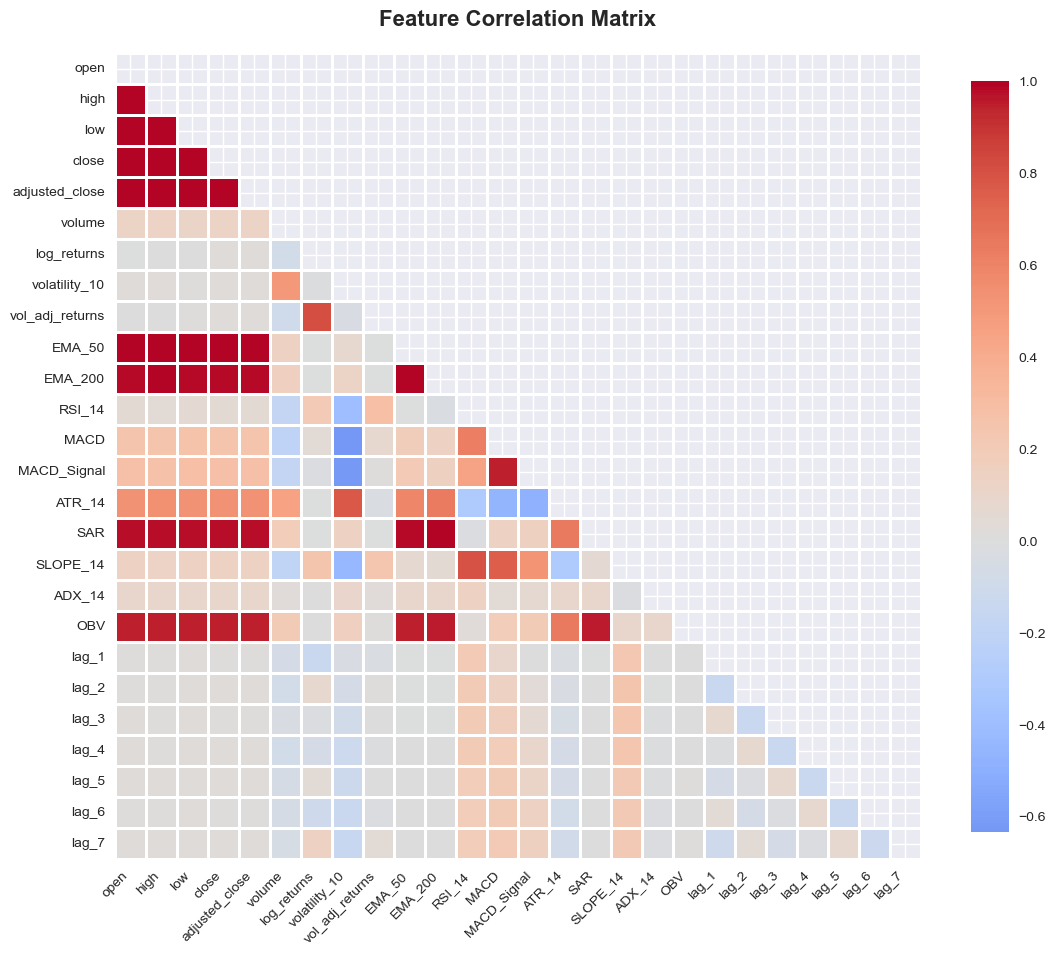

In [13]:
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Generate a mask to hide the upper triangle (reduce redundancy)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Dynamic figure sizing based on the number of features
n_features = corr_matrix.shape[0]
plt.figure(figsize=(n_features * 0.5, n_features * 0.5))  # Adjust multiplier if needed

sns.heatmap(
    corr_matrix, mask=mask, annot=False, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=1, cbar_kws={"shrink": 0.75}, square=True
)

# Label formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Feature Correlation Matrix", fontsize=16, fontweight='bold', pad=20)

# Save figure (Change filename & format as needed)
plt.savefig(OUTPUT_DIR / "3_feature_correlation_matrix.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Definition of Target Variable (`d`)

In [14]:
# --- Define Target Variable (d = next-day direction) ---
df['d'] = np.where(df['log_returns'].shift(-1) > 0, 1, 0)
df.dropna(subset=['d'], inplace=True)

# --- Corrected Feature Selection (X) ---
X = df[[col for col in [
    'open', 'high', 'low', 'close', 'adjusted_close', 'volume', 'log_returns', 
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 
    'volatility_10', 'vol_adj_returns', 'EMA_50', 'EMA_200',
    'RSI_14', 'MACD', 'MACD_Signal', 'ATR_14', 'SAR',
    'SLOPE_14', 'ADX_14', 'OBV', 'SMA_50_regime', 'SMA_200_regime', 
    'volatility_10_regime', 'RSI_14_regime', 'regime', 'regime_1', 'regime_2', 'regime_3'
] if col in df.columns]]  # Only include columns that exist

# --- Define Target Variable (y) ---
y = df['d']

# Preview
display(df.tail())

,open,high,low,close,adjusted_close,volume,log_returns,volatility_10,vol_adj_returns,EMA_50,...,ADX_14,OBV,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,d
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-03,5968.3301,5986.0898,5810.9102,5849.7202,5849.7202,5613850000,-0.017753,0.010518,-1.687854,5994.162275,...,23.276308,6.772605e+11,0.015730,-0.015992,0.000136,-0.004691,-0.004981,-0.017211,-0.004344,0
2025-03-04,5811.9800,5865.0801,5732.5898,5778.1499,5778.1499,6138110000,-0.012310,0.010482,-1.174418,5985.691202,...,26.684097,6.711224e+11,-0.017753,0.015730,-0.015992,0.000136,-0.004691,-0.004981,-0.017211,1
2025-03-05,5781.3599,5860.5898,5742.3501,5842.6299,5842.6299,5285970000,0.011097,0.011556,0.960360,5980.080954,...,29.099143,6.764084e+11,-0.012310,-0.017753,0.015730,-0.015992,0.000136,-0.004691,-0.004981,0
2025-03-06,5785.8701,5812.0801,5711.6401,5738.5200,5738.5200,5165080000,-0.017980,0.012249,-1.467844,5970.607976,...,33.535151,6.712433e+11,0.011097,-0.012310,-0.017753,0.015730,-0.015992,0.000136,-0.004691,1
2025-03-07,5726.0098,5783.0098,5666.2900,5770.2002,5770.2002,5705140000,0.005505,0.012126,0.454013,5962.748847,...,37.614856,6.769485e+11,-0.017980,0.011097,-0.012310,-0.017753,0.015730,-0.015992,0.000136,0


In [15]:
print(df['d'].value_counts(normalize=True))

d
1    0.540637
0    0.459363
Name: proportion, dtype: float64


### Feature Selection Using `ExtraTreesClassifier`

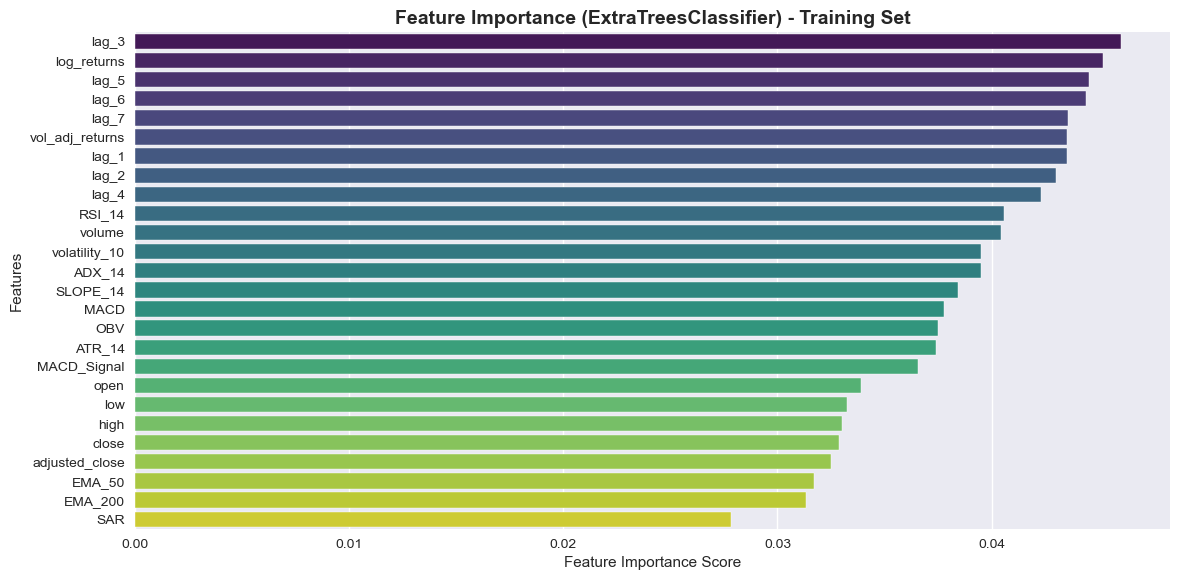

Top 15 features (Training Set): ['lag_3', 'log_returns', 'lag_5', 'lag_6', 'lag_7', 'vol_adj_returns', 'lag_1', 'lag_2', 'lag_4', 'RSI_14', 'volume', 'volatility_10', 'ADX_14', 'SLOPE_14', 'MACD']


In [16]:
# 1) Define a chronological cutoff date
train_cutoff = '2022-01-01'  # or pick another date

df_train = df.loc[:train_cutoff]
df_test = df.loc[train_cutoff:]

X_train = X.loc[df_train.index]
y_train = y.loc[df_train.index]
X_test = X.loc[df_test.index]
y_test = y.loc[df_test.index]

# 2) Fit ExtraTrees ONLY on the training set
model_fs = ExtraTreesClassifier(n_estimators=100, random_state=42)
model_fs.fit(X_train, y_train)

# 3) Extract feature importances from TRAINING
feature_importance = pd.Series(
    model_fs.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# (Optional) plot these feature importances
plt.figure(figsize=(12, 6))
sns.barplot(
    x=feature_importance.values, 
    y=feature_importance.index, 
    hue=feature_importance.index,
    palette="viridis",
    dodge=False,
    legend=False
)
plt.title("Feature Importance (ExtraTreesClassifier) - Training Set", fontsize=14, fontweight='bold')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "4_feature_importance_extratrees.png", dpi=300, bbox_inches='tight')  # or .pdf/.svg if needed
plt.show()

# 4) Select top N features from TRAINING
n_top = 15
top_features = feature_importance.index[:n_top]
print(f"Top {n_top} features (Training Set):", top_features.tolist())

# 5) Apply these features to both train & test
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

### Preparation of `X` and `y` for LSTM Model

⚠️ Note: Legacy full-dataset HMM regime columns have been purged to prevent leakage. Only per-fold regime features (via `fit_transform_regime_features_fold`) are used in training.


In [17]:
FEATURE_COLS = [col for col in top_features if not col.startswith("regime_") and col != "regime"] 

In [18]:
# Confirm no regime features slipped in
assert all(not f.startswith("regime") for f in FEATURE_COLS), "Regime leak detected!"

# Model Implementation & Training
## Model Definition & Initialization

#### ATT-LSTM Model

In [19]:
# ================================
# Prediction Thresholds
# ================================
PRED_THRESHOLD = 0.5   # central cutoff
THRESH_BAND = 0.05     # neutral zone half-width

LONG_THRESHOLD  = PRED_THRESHOLD + THRESH_BAND  # e.g., 0.55
SHORT_THRESHOLD = PRED_THRESHOLD - THRESH_BAND  # e.g., 0.45

print(f'Thresholds set -> SHORT={SHORT_THRESHOLD}, LONG={LONG_THRESHOLD}')

Thresholds set -> SHORT=0.45, LONG=0.55


In [20]:
# Sequence preparation helper (per-fold pipeline)
SEQ_LEN = 28

def create_sequences(X_input, y_input, seq_length=SEQ_LEN):
    """Convert 2D arrays into overlapping sequences paired with next-step labels."""
    X_values = X_input.values if hasattr(X_input, "values") else np.asarray(X_input)
    y_values = y_input.values if hasattr(y_input, "values") else np.asarray(y_input)

    if len(X_values) <= seq_length:
        raise ValueError("Sequence length must be smaller than the number of samples.")

    X_seq = np.array([
        X_values[i : i + seq_length]
        for i in range(len(X_values) - seq_length)
    ])
    y_seq = y_values[seq_length:]
    return X_seq, y_seq

In [21]:
# === Weighted-sum (Bahdanau-style) attention ===
import tensorflow as tf
from tensorflow.keras.layers import Dense, Softmax, Lambda

def weighted_sum_attention(H, attn_units: int = 32):
    # H: (batch, T, d)
    e = Dense(attn_units, activation='tanh', name='attn_dense')(H)   # (batch, T, attn_units)
    e = Dense(1, name='attn_score')(e)                               # (batch, T, 1)
    alpha = Softmax(axis=1, name='attn_weights')(e)                   # (batch, T, 1), sum_t alpha = 1
    context = Lambda(lambda xs: tf.reduce_sum(xs[0] * xs[1], axis=1),
                     name='attn_context')([alpha, H])                 # (batch, d)
    return context, alpha

In [22]:
ATTN_PLOTS_DIR = OUTPUT_DIR / 'attn_plots'
ATTN_PLOTS_DIR.mkdir(parents=True, exist_ok=True)


def plot_attention_heatmap(att_weights, dates, fold):
    """Save a heatmap of attention weights for inspection."""
    att_array = np.array(att_weights)
    if att_array.ndim == 3 and att_array.shape[-1] == 1:
        att_array = att_array.squeeze(-1)
    if att_array.ndim != 2:
        raise ValueError(f"Expected attention weights with shape (samples, timesteps); got {att_array.shape}")

    # Ensure dates align with samples
    dates = pd.to_datetime(dates)
    if att_array.shape[0] != len(dates):
        raise ValueError("Attention weights and dates have mismatched lengths")

    plt.figure(figsize=(8, 6))
    im = plt.imshow(att_array, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Attention Weight')
    plt.xlabel('Timestep')
    plt.ylabel('Validation Date')

    # Manage y-axis ticks to avoid overcrowding
    step = max(1, len(dates) // 12)
    tick_idx = range(0, len(dates), step)
    tick_labels = [dates[i].strftime('%Y-%m-%d') for i in tick_idx]
    plt.yticks(tick_idx, tick_labels, fontsize=7)
    plt.title(f'Attention Heatmap - Fold {fold}')
    plt.tight_layout()

    out_path = ATTN_PLOTS_DIR / f'attn_heatmap_fold_{fold}.png'
    plt.savefig(out_path, dpi=150)
    plt.close()

In [23]:
# ================================
# Hyperparameters
# ================================
EPOCHS = 60
BATCH_SIZE = 32
LEARNING_RATE = 0.001   # tuned lower for stability
LSTM_UNITS = 64
DROPOUT_RATE = 0.2

# ====================================================
# Attention-LSTM model factory
# ====================================================
def get_att_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM encoder
    lstm_out = LSTM(
        LSTM_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE,
        recurrent_dropout=0.1,
        kernel_regularizer=l2(1e-5)
    )(inputs)
    lstm_out = BatchNormalization()(lstm_out)

    # Weighted-sum attention
    context, att_weights = weighted_sum_attention(lstm_out, attn_units=32)

    # Output layer
    outputs = Dense(1, activation="sigmoid")(context)

    model = Model(inputs, outputs)
    attention_model = Model(inputs, att_weights, name='attention_extractor')
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=LEARNING_RATE, clipnorm=1.0),
        metrics=["accuracy"]
    )
    return model, attention_model

model, attention_model = get_att_lstm_model((SEQ_LEN, len(FEATURE_COLS)))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 15)]             0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 28, 64)               20480     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 64)               256       ['lstm[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 attn_dense (Dense)          (None, 28, 32)               2080      ['batch_normalization[0][0

#### *Attention Extractor Model*

In [24]:
attention_model.summary()

Model: "attention_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 15)]          0         
                                                                 
 lstm (LSTM)                 (None, 28, 64)            20480     
                                                                 
 batch_normalization (Batch  (None, 28, 64)            256       
 Normalization)                                                  
                                                                 
 attn_dense (Dense)          (None, 28, 32)            2080      
                                                                 
 attn_score (Dense)          (None, 28, 1)             33        
                                                                 
 attn_weights (Softmax)      (None, 28, 1)             0         
                                               

In [25]:
# Cross-Validated Training (ATT-LSTM)
from sklearn.metrics import roc_curve, auc

HMM_FEATURE_COLS = ['log_returns', 'volatility_10', 'RSI_14', 'MACD', 'ATR_14', 'OBV']
X_train_base = X_train[FEATURE_COLS]
regime_spec = RegimeSpec(covariance_type='diag', n_iter=100, tol=1e-2, reg_covar=1e-3)

tscv = TimeSeriesSplit(n_splits=6, test_size=252)

predictions, true_labels = [], []
fold_metrics = []
pred_index_buffer = []
train_sequence_labels = []
roc_curves = []
last_model = None
last_scaler = None

print(f'Using thresholds -> SHORT={SHORT_THRESHOLD}, LONG={LONG_THRESHOLD}')

for fold, (train_idx_pos, val_idx_pos) in enumerate(tscv.split(X_train_base)):
    train_idx = X_train_base.index[train_idx_pos]
    val_idx = X_train_base.index[val_idx_pos]

    reg_train, reg_val = fit_transform_regime_features_fold(
        df, HMM_FEATURE_COLS, train_idx, val_idx, spec=regime_spec
    )

    base_train = df.loc[train_idx, FEATURE_COLS].values
    base_val = df.loc[val_idx, FEATURE_COLS].values

    X_train_2d = np.hstack([base_train, reg_train])
    X_val_2d = np.hstack([base_val, reg_val])

    scaler = get_fold_scaler(X_train_2d)
    X_train_scaled_2d = scaler.transform(X_train_2d)
    X_val_scaled_2d = scaler.transform(X_val_2d)

    y_train_fold = y.loc[train_idx]
    y_val_fold = y.loc[val_idx]

    X_seq_train_fold, y_seq_train_fold = create_sequences(X_train_scaled_2d, y_train_fold, SEQ_LEN)
    X_seq_val_fold, y_seq_val_fold = create_sequences(X_val_scaled_2d, y_val_fold, SEQ_LEN)

    train_sequence_labels.extend(y_seq_train_fold.tolist())

    train_end_ts = train_idx[-1]
    val_start_ts = val_idx[0]
    assert_no_future_fit(train_end_ts, val_start_ts)
    print(f'[Fold {fold}] Train end: {train_end_ts}, Val start: {val_start_ts}, Train size={len(train_idx)}, Val size={len(val_idx)}')

    input_shape = (X_seq_train_fold.shape[1], X_seq_train_fold.shape[2])
    model, attention_model = get_att_lstm_model(input_shape)

    early_stopping_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=0)
    checkpoint_cb = ModelCheckpoint(
        filepath=str(OUTPUT_DIR / f'att_lstm_best_fold_{fold}.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=0,
        save_format='h5'
    )

    model.fit(
        X_seq_train_fold,
        y_seq_train_fold,
        validation_data=(X_seq_val_fold, y_seq_val_fold),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0,
        callbacks=[early_stopping_cb, reduce_lr_cb, checkpoint_cb]
    )

    pred = model.predict(X_seq_val_fold, verbose=0).flatten()
    val_seq_index = val_idx[SEQ_LEN:]
    att_weights = attention_model.predict(X_seq_val_fold, verbose=0)
    weights_array = np.array(att_weights)
    if weights_array.ndim == 3 and weights_array.shape[-1] == 1:
        weights_array = weights_array.squeeze(-1)
    np.save(OUTPUT_DIR / f"attn_weights_fold_{fold}.npy", weights_array)
    plot_attention_heatmap(weights_array, val_seq_index, fold)
    print(f"Saved attention weights and heatmap for fold {fold}")
    fpr, tpr, _ = roc_curve(y_seq_val_fold, pred)
    roc_auc = auc(fpr, tpr)
    roc_curves.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

    pred_index_buffer.extend(val_seq_index)
    predictions.extend(pred)
    true_labels.extend(y_seq_val_fold)

    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy_score(y_seq_val_fold, (pred >= PRED_THRESHOLD).astype(int)),
        'precision': precision_score(y_seq_val_fold, (pred >= PRED_THRESHOLD).astype(int), zero_division=0),
        'recall': recall_score(y_seq_val_fold, (pred >= PRED_THRESHOLD).astype(int), zero_division=0),
        'f1_score': f1_score(y_seq_val_fold, (pred >= PRED_THRESHOLD).astype(int), zero_division=0)
    })

    last_model = model
    last_scaler = scaler

pred_index = pd.DatetimeIndex(pred_index_buffer)
train_sequence_labels = np.array(train_sequence_labels)
predictions = np.array(predictions)
true_labels = np.array(true_labels)
pred = predictions

# Persist results immediately for downstream steps
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
np.save(OUTPUT_DIR / 'predictions.npy', predictions)
np.save(OUTPUT_DIR / 'true_labels.npy', true_labels)
np.save(OUTPUT_DIR / 'pred_index.npy', pred_index.values.astype('datetime64[ns]'))
print(f"Saved CV artifacts -> predictions={len(predictions)}, true_labels={len(true_labels)}, pred_index={len(pred_index)}")
df_fold_metrics = pd.DataFrame(fold_metrics)
df_fold_metrics.to_csv(OUTPUT_DIR / 'fold_metrics.csv', index=False)

print('Fold Metrics:')
display(df_fold_metrics)

predictions_binary = (predictions >= PRED_THRESHOLD).astype(int)
print('Cross-Validated Model Performance (Training Set):')
print(f"Accuracy: {accuracy_score(true_labels, predictions_binary):.4f}")
print(f"Precision: {precision_score(true_labels, predictions_binary, zero_division=0):.4f}")
print(f"Recall: {recall_score(true_labels, predictions_binary, zero_division=0):.4f}")
print(f"F1-score: {f1_score(true_labels, predictions_binary, zero_division=0):.4f}")

print('Mean Fold Performance:')
print(df_fold_metrics[["accuracy", "precision", "recall", "f1_score"]].mean())

Using thresholds -> SHORT=0.45, LONG=0.55
[Fold 0] Train end: 2015-12-30 00:00:00, Val start: 2015-12-31 00:00:00, Train size=484, Val size=252
Saved attention weights and heatmap for fold 0
[Fold 1] Train end: 2016-12-29 00:00:00, Val start: 2016-12-30 00:00:00, Train size=736, Val size=252
Saved attention weights and heatmap for fold 1
[Fold 2] Train end: 2017-12-29 00:00:00, Val start: 2018-01-02 00:00:00, Train size=988, Val size=252
Saved attention weights and heatmap for fold 2
[Fold 3] Train end: 2019-01-02 00:00:00, Val start: 2019-01-03 00:00:00, Train size=1240, Val size=252
Saved attention weights and heatmap for fold 3
[Fold 4] Train end: 2020-01-02 00:00:00, Val start: 2020-01-03 00:00:00, Train size=1492, Val size=252
Saved attention weights and heatmap for fold 4
[Fold 5] Train end: 2020-12-31 00:00:00, Val start: 2021-01-04 00:00:00, Train size=1744, Val size=252
Saved attention weights and heatmap for fold 5
Saved CV artifacts -> predictions=1344, true_labels=1344, pre

,fold,accuracy,precision,recall,f1_score
0,1,0.459821,0.489362,0.386555,0.431925
1,2,0.575893,0.577465,0.960938,0.721408
2,3,0.513393,0.513393,1.000000,0.678466
3,4,0.580357,0.579186,0.992248,0.731429
4,5,0.575893,0.577114,0.920635,0.709480
5,6,0.535714,0.558011,0.808000,0.660131


Cross-Validated Model Performance (Training Set):
Accuracy: 0.5402
Precision: 0.5547
Recall: 0.8477
F1-score: 0.6706
Mean Fold Performance:
accuracy     0.540179
precision    0.549088
recall       0.844729
f1_score     0.655473
dtype: float64


In [26]:
# Manual persistence helper (useful after interactive tweaks)
required_names = ['predictions', 'true_labels', 'pred_index']
if all(name in globals() for name in required_names):
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    np.save(OUTPUT_DIR / 'predictions.npy', predictions)
    np.save(OUTPUT_DIR / 'true_labels.npy', true_labels)
    np.save(OUTPUT_DIR / 'pred_index.npy', pred_index.values.astype('datetime64[ns]'))
    print(f"Saved predictions, true_labels, and pred_index to disk ({len(predictions)} samples).")
else:
    print('Run "Cross-Validated Training (ATT-LSTM)" before saving predictions to disk.')

Saved predictions, true_labels, and pred_index to disk (1344 samples).


#### `Saving & Logging`

In [27]:
import shutil

if 'last_model' in globals() and last_model is not None:
    last_model.save('best_att_lstm_model.keras')
    shutil.copy('best_att_lstm_model.keras', 'best_att_lstm_model_backup.keras')
    print('Attention-LSTM model saved successfully.')
else:
    print('No trained Attention-LSTM model found. Run training first.')

Attention-LSTM model saved successfully.


## Attention Inspection & Visualization

Loaded attention weights for 6 folds; each with 28 timesteps.


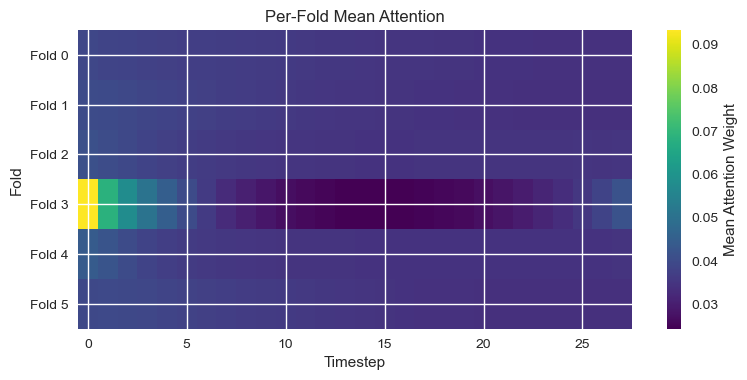

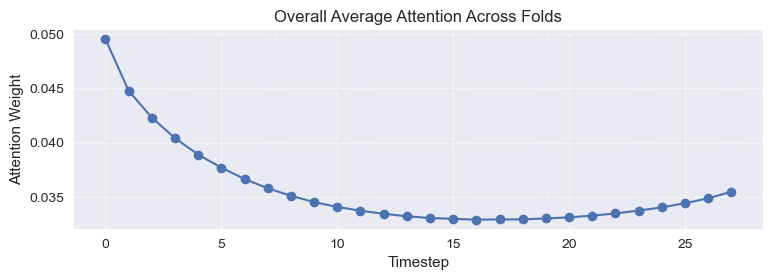

Saved attention summary heatmap: ../outputs/04_ATT_LSTM/attn_plots/attn_summary_heatmap.png
Saved attention mean plot: ../outputs/04_ATT_LSTM/attn_plots/attn_summary_mean.png


In [28]:
# Attention inspection across folds
import numpy as np
import matplotlib.pyplot as plt
import glob

attn_files = sorted(glob.glob(str(OUTPUT_DIR / 'attn_weights_fold_*.npy')))
if not attn_files:
    print('No attention weight files found. Run CV training first.')
else:
    fold_means = []
    for file in attn_files:
        try:
            weights = np.load(file)
        except Exception as exc:
            print(f'Failed to load {file}: {exc}')
            continue
        if weights.ndim == 3 and weights.shape[-1] == 1:
            weights = weights.squeeze(-1)
        if weights.ndim != 2:
            print(f'Skipping {file}; unexpected shape {weights.shape}')
            continue
        fold_means.append(weights.mean(axis=0))

    if not fold_means:
        print('Attention files loaded but no valid arrays found.')
    else:
        fold_means = np.stack(fold_means, axis=0)
        folds, timesteps = fold_means.shape
        print(f'Loaded attention weights for {folds} folds; each with {timesteps} timesteps.')

        ATTN_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

        # Heatmap across folds
        plt.figure(figsize=(8, 4))
        im = plt.imshow(fold_means, aspect='auto', cmap='viridis')
        plt.colorbar(im, label='Mean Attention Weight')
        plt.xlabel('Timestep')
        plt.ylabel('Fold')
        plt.yticks(range(folds), [f'Fold {i}' for i in range(folds)])
        plt.title('Per-Fold Mean Attention')
        plt.tight_layout()
        heatmap_path = ATTN_PLOTS_DIR / 'attn_summary_heatmap.png'
        plt.savefig(heatmap_path, dpi=150)
        plt.show()
        plt.close()

        # Overall average attention
        overall_mean = fold_means.mean(axis=0)
        plt.figure(figsize=(8, 3))
        plt.plot(range(timesteps), overall_mean, marker='o', linewidth=1.5)
        plt.xlabel('Timestep')
        plt.ylabel('Attention Weight')
        plt.title('Overall Average Attention Across Folds')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        mean_path = ATTN_PLOTS_DIR / 'attn_summary_mean.png'
        plt.savefig(mean_path, dpi=150)
        plt.show()
        plt.close()

        print(f'Saved attention summary heatmap: {heatmap_path}')
        print(f'Saved attention mean plot: {mean_path}')

# Trading Signal Generation and Backtesting Module

In [29]:
# ====================================================
# Backtesting Module (Config + Alignment + Engine)
# ====================================================
@dataclass
class BTConfig:
    # Signal thresholds (probabilities)
    long_threshold: float = LONG_THRESHOLD
    short_threshold: float = SHORT_THRESHOLD
    neutral_band: bool = True  # if True, do nothing in (short_th, long_th)

    # Position management
    min_hold_days: int = 3              # minimum holding period (bars)
    stop_daily: float = -0.015          # daily stop: exit if pos*ret <= this (log-return)
    stop_trailing: float = -0.06        # trailing stop since entry (log-return)
    roll_loss_window: int = 12          # rolling window for loss exit
    roll_loss_thresh: float = -0.035     # exit if rolling pos*ret sum < this

    # Vol targeting
    use_vol_targeting: bool = True
    vol_window: int = 20                # rolling window for realized vol (daily)
    target_annual_vol: float = 0.10     # e.g., 15% annual vol target
    max_leverage: float = 1.8           # cap on |position_size|
    vol_floor: float = 1e-6             # avoid div by zero

    # Transaction costs
    cost_bps_per_turnover: float = 5   # 10 bps per unit turnover (0.001 = 10 bps)
    slippage_bps: float = 0.0           # optional extra slippage per trade leg

def align_predictions_to_df(df: pd.DataFrame,
                            predictions: np.ndarray | pd.Series,
                            pred_index: pd.DatetimeIndex | None = None,
                            column_name: str = "p") -> pd.Series:
    """
    Returns a Series aligned to df.index containing the predictions.
    If pred_index is provided, we reindex to df (preserving order).
    Otherwise we right-align to the last len(predictions) rows.
    """
    if isinstance(predictions, pd.Series):
        s = predictions.copy()
    else:
        if pred_index is not None:
            s = pd.Series(predictions, index=pred_index)
        else:
            if len(predictions) > len(df):
                raise ValueError("predictions length exceeds df length; provide pred_index to align.")
            s = pd.Series(predictions, index=df.index[-len(predictions):])
    return s.reindex(df.index).rename(column_name)

def run_backtest_clean(
    df: pd.DataFrame,
    predictions: np.ndarray | pd.Series,
    pred_index: pd.DatetimeIndex | None = None,
    cfg: BTConfig = BTConfig(),
    price_col: str = "adjusted_close",
    ret_col: str = "log_returns",
) -> tuple[pd.DataFrame, dict]:
    """
    Clean event-driven backtest with:
      - strict alignment & no look-ahead
      - min hold, daily stop, trailing stop, rolling-loss exit
      - volatility targeting with caps & floors
      - turnover-based transaction costs
      - buy/hold benchmark & performance summary

    Requires df[ret_col] (daily log returns) and df[price_col] (for benchmark).
    """
    if ret_col not in df.columns:
        raise KeyError(f"Expected {ret_col} in df")
    if price_col not in df.columns:
        raise KeyError(f"Expected {price_col} in df")
    print(f'Using PRED_THRESHOLD={PRED_THRESHOLD}, LONG={LONG_THRESHOLD}, SHORT={SHORT_THRESHOLD}')

    out = df[[ret_col, price_col]].copy()
    out["p"] = align_predictions_to_df(df, predictions, pred_index, "p")

    # 1) Raw signal from probabilities
    if cfg.neutral_band:
        out["raw_signal"] = np.select(
            [out["p"] >= cfg.long_threshold, out["p"] <= cfg.short_threshold],
            [1, -1],
            default=0
        )
    else:
        out["raw_signal"] = np.where(out["p"] >= cfg.long_threshold, 1, -1)
    # 2) Realized volatility & position sizing scalar
    if cfg.use_vol_targeting:
        vol = out[ret_col].rolling(cfg.vol_window).std()
        # Fill early NaNs with expanding std as a reasonable fallback, then final backstop
        vol = vol.fillna(out[ret_col].expanding().std()).fillna(0.0)
        out["vol_est_daily"] = vol

        target_daily_vol = cfg.target_annual_vol / np.sqrt(252.0)
        denom = out["vol_est_daily"].clip(lower=cfg.vol_floor)
        scale = (target_daily_vol / denom).clip(upper=cfg.max_leverage)
        # Final safety: if anything is still NA/inf, default to 1.0
        scale = scale.replace([np.inf, -np.inf], np.nan).fillna(1.0)
    else:
        scale = pd.Series(1.0, index=out.index)

    # 3) Event-driven loop (no look-ahead)
    pos = 0            # direction: -1, 0, +1
    size = 0.0         # signed position size after vol targeting
    days_held = 0
    entry_cum_logret = 0.0
    rolling_buf: list[float] = []

    pos_hist, size_hist = [], []
    daily_pos_ret, turn_hist, cost_hist = [], [], []
    trail_hist, sig_hist = [], []

    cost_per_turnover = (cfg.cost_bps_per_turnover + cfg.slippage_bps) / 1e4

    for i, idx in enumerate(out.index):
        p = out.at[idx, "p"]
        r = out.at[idx, ret_col]
        s_raw = out.at[idx, "raw_signal"]

        # Desired direction (respect min_hold_days)
        desired_pos = pos
        if not np.isnan(p):
            if days_held > 0:
                desired_pos = pos
                days_held -= 1
            else:
                desired_pos = s_raw

        # Use previous size for today's P&L (no look-ahead)
        daily_pret = size * r
        daily_pos_ret.append(daily_pret)

        # Update trailing since entry
        if pos == 0:
            entry_cum_logret = 0.0
        else:
            entry_cum_logret += daily_pret
        trail_hist.append(entry_cum_logret)

        # Rolling loss buffer (pos*ret)
        rolling_buf.append(daily_pret)
        if len(rolling_buf) > cfg.roll_loss_window:
            rolling_buf.pop(0)
        rolling_sum = float(np.sum(rolling_buf))

        # Check exits (hard exits override desired entries)
        exit_signal = False
        if pos != 0:
            if daily_pret <= cfg.stop_daily:
                exit_signal = True
            if entry_cum_logret <= cfg.stop_trailing:
                exit_signal = True
            if (len(rolling_buf) == cfg.roll_loss_window) and (rolling_sum <= cfg.roll_loss_thresh):
                exit_signal = True

        # Determine next position (direction), respecting exits
        next_pos = 0 if exit_signal else desired_pos

        # Compute next size with vol targeting
        s = float(scale.iloc[i])
        next_size = float(np.clip(next_pos * s, -cfg.max_leverage, cfg.max_leverage))

        # Turnover & cost applied on change from current size -> next size
        turnover = abs(next_size - size)
        cost = cost_per_turnover * turnover

        # Record & advance
        pos_hist.append(pos)
        size_hist.append(size)
        turn_hist.append(turnover)
        cost_hist.append(cost)
        sig_hist.append(s_raw)

        # If we open a new position, (0 -> ±1) enforce min hold going forward
        if (pos == 0) and (next_pos != 0):
            days_held = max(cfg.min_hold_days - 1, 0)
            entry_cum_logret = 0.0

        pos = next_pos
        size = next_size

    out["pos_dir_prev"]   = pos_hist           # previous-bar direction (info)
    out["pos_size_prev"]  = size_hist          # previous-bar size used for P&L
    out["signal_raw"]     = sig_hist
    out["turnover"]       = turn_hist
    out["cost"]           = cost_hist
    out["pos_ret"]        = daily_pos_ret      # size_prev * ret
    out["pos_trail"]      = trail_hist

    # Net strategy log return (subtract costs)
    out["strat_log_ret"] = out["pos_ret"] - out["cost"]

    # Equity curves
    out["strategy_equity"] = np.exp(out["strat_log_ret"].cumsum())
    out["bh_log_ret"]      = out[ret_col]  # buy & hold (1x)
    out["bh_equity"]       = np.exp(out["bh_log_ret"].cumsum())

    # Focus metrics on the period where we actually had predictions
    mask_test = out["p"].notna()
    test = out.loc[mask_test].copy()
    if test.empty:
        raise ValueError("No rows with predictions; check alignment.")

    # Performance summary helpers
    def max_drawdown(equity: pd.Series) -> float:
        roll_max = equity.cummax()
        dd = equity / roll_max - 1.0
        return float(dd.min())  # negative number

    def annualize_mean_logret(daily_logret: pd.Series) -> float:
        return float(daily_logret.mean() * 252.0)

    def annualize_vol(daily_logret: pd.Series) -> float:
        return float(daily_logret.std(ddof=0) * np.sqrt(252.0))

    # Strategy stats
    strat_log = test["strat_log_ret"]
    bh_log    = test["bh_log_ret"]

    strat_total_ret = float(np.exp(strat_log.sum()) - 1.0)
    bh_total_ret    = float(np.exp(bh_log.sum()) - 1.0)

    strat_cagr = float(np.exp(annualize_mean_logret(strat_log)) - 1.0)
    bh_cagr    = float(np.exp(annualize_mean_logret(bh_log)) - 1.0)

    strat_vol = annualize_vol(strat_log)
    bh_vol    = annualize_vol(bh_log)

    # Add tiny epsilon to avoid 0/0
    eps = 1e-12
    strat_sharpe = float(annualize_mean_logret(strat_log) / (strat_vol + eps))
    bh_sharpe    = float(annualize_mean_logret(bh_log) / (bh_vol + eps))

    strat_mdd = max_drawdown(test["strategy_equity"])
    bh_mdd    = max_drawdown(test["bh_equity"])

    turnover_sum = float(test["turnover"].sum())
    # Fraction of profitable days while exposed (size_prev ≠ 0)
    exposed = test["pos_size_prev"] != 0
    hit_rate = float((test.loc[exposed, "pos_ret"] > 0).mean()) if exposed.any() else np.nan

    summary = {
        "window_start": str(test.index[0].date()),
        "window_end":   str(test.index[-1].date()),
        "bars": int(len(test)),
        "total_return":      strat_total_ret,
        "bh_total_return":   bh_total_ret,
        "cagr":              strat_cagr,
        "bh_cagr":           bh_cagr,
        "ann_vol":           strat_vol,
        "bh_ann_vol":        bh_vol,
        "sharpe":            strat_sharpe,
        "bh_sharpe":         bh_sharpe,
        "max_drawdown":      strat_mdd,
        "bh_max_drawdown":   bh_mdd,
        "turnover":          turnover_sum,
        "hit_rate":          hit_rate,
        "avg_daily_cost_bps": float(test["cost"].mean() * 1e4),
        "avg_daily_exposure": float(test["pos_size_prev"].abs().mean()),
    }

    return out, summary

## Threshold Calibration (Stage A)

Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45


,threshold,long_threshold,short_threshold,sharpe,cagr,hit_rate,max_drawdown
0,0.40,0.45,0.35,0.607474,0.067822,0.553945,-0.114502
1,0.42,0.47,0.37,0.632001,0.070177,0.557551,-0.114502
2,0.44,0.49,0.39,0.606098,0.065322,0.556332,-0.120825
3,0.46,0.51,0.41,0.892744,0.084988,0.564263,-0.139273
4,0.48,0.53,0.43,0.746318,0.056715,0.562112,-0.098697
5,0.50,0.55,0.45,0.145789,0.007532,0.556213,-0.105974
6,0.52,0.57,0.47,0.603115,0.020653,0.564516,-0.043942
7,0.54,0.59,0.49,-0.151446,-0.004917,0.457364,-0.105997
8,0.56,0.61,0.51,-0.255032,-0.014266,0.473054,-0.153771
9,0.58,0.63,0.53,-0.680024,-0.053305,0.455657,-0.313165


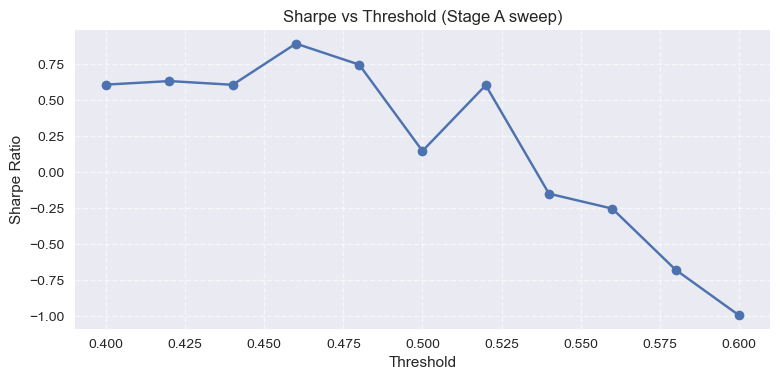

Threshold sweep saved to ../outputs/04_ATT_LSTM/threshold_sweep.csv and ../outputs/04_ATT_LSTM/threshold_sweep.png


In [30]:
# ================================
# Threshold Calibration (Stage A)
# ================================
missing = [n for n in ['BTConfig', 'run_backtest_clean', 'df'] if n not in globals()]
if missing:
    print(f"Threshold sweep skipped – missing {missing}. Run the backtesting module cells first.")
else:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    pred_path = OUTPUT_DIR / 'predictions.npy'
    label_path = OUTPUT_DIR / 'true_labels.npy'
    index_path = OUTPUT_DIR / 'pred_index.npy'

    if not (pred_path.exists() and label_path.exists() and index_path.exists()):
        print('Threshold sweep skipped – run the CV training/persistence cells first.')
    else:
        predictions = np.load(pred_path, allow_pickle=False)
        true_labels = np.load(label_path, allow_pickle=False)
        pred_index = pd.to_datetime(np.load(index_path, allow_pickle=False))

        thresholds = np.round(np.arange(0.40, 0.6001, 0.02), 2)
        results = []
        preds_series = pd.Series(predictions, index=pred_index)

        for th in thresholds:
            long_th = min(0.99, th + 0.05)
            short_th = max(0.01, th - 0.05)
            cfg = BTConfig(long_threshold=long_th, short_threshold=short_th)

            df_bt, summary = run_backtest_clean(df, preds_series, pred_index=pred_index, cfg=cfg)
            results.append({
                'threshold': th,
                'long_threshold': long_th,
                'short_threshold': short_th,
                'sharpe': summary.get('sharpe'),
                'cagr': summary.get('cagr'),
                'hit_rate': summary.get('hit_rate'),
                'max_drawdown': summary.get('max_drawdown')
            })

        df_thresh = pd.DataFrame(results)
        df_thresh.to_csv(OUTPUT_DIR / 'threshold_sweep.csv', index=False)
        display(df_thresh)

        plt.figure(figsize=(8, 4))
        plt.plot(df_thresh['threshold'], df_thresh['sharpe'], marker='o')
        plt.xlabel('Threshold')
        plt.ylabel('Sharpe Ratio')
        plt.title('Sharpe vs Threshold (Stage A sweep)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'threshold_sweep.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Threshold sweep saved to {OUTPUT_DIR / 'threshold_sweep.csv'} and {OUTPUT_DIR / 'threshold_sweep.png'}")



In [31]:
import json
from tabulate import tabulate
# Ensure predictions are available (either from current session or persisted files)
files_exist = OUTPUT_DIR.exists() and all((OUTPUT_DIR / fname).exists() for fname in ['predictions.npy', 'true_labels.npy', 'pred_index.npy'])

if 'predictions' in globals() and 'pred_index' in globals():
    print('Using predictions from memory.')
elif files_exist:
    print('Loading predictions from disk...')
    predictions = np.load(OUTPUT_DIR / 'predictions.npy', allow_pickle=False)
    true_labels = np.load(OUTPUT_DIR / 'true_labels.npy', allow_pickle=False)
    pred_index = pd.to_datetime(np.load(OUTPUT_DIR / 'pred_index.npy', allow_pickle=False))
    print('Loaded predictions, true_labels, and pred_index from disk.')
else:
    print('No cached CV artifacts found. Run the CV training/persistence cells, then rerun this backtest cell.')

if ('predictions' in globals() and 'pred_index' in globals()) or files_exist:
    labels = None
    if 'true_labels' in globals():
        labels = true_labels
    elif files_exist:
        labels = np.load(OUTPUT_DIR / 'true_labels.npy', allow_pickle=False)
        true_labels = labels
    if 'df_backtest' in globals():
        print('Warning: Overwriting existing backtest results.')

    df_backtest, bt_summary = run_backtest_clean(df, predictions, pred_index=pred_index)

    # Classification diagnostics
    roc_auc = np.nan
    pr_auc = np.nan
    if labels is not None:
        try:
            roc_auc = roc_auc_score(labels, predictions)
        except ValueError:
            pass
        try:
            pr_auc = average_precision_score(labels, predictions)
        except ValueError:
            pass
    bt_summary['roc_auc'] = roc_auc
    bt_summary['pr_auc'] = pr_auc

    # Persist summary
    summary_json = OUTPUT_DIR / 'backtest_summary.json'
    with summary_json.open('w') as fh:
        json.dump(bt_summary, fh, indent=2)

    summary_csv = OUTPUT_DIR / 'backtest_summary.csv'
    pd.DataFrame([bt_summary]).to_csv(summary_csv, index=False)

    # Format summary for display
    cleaned = {}
    for k, v in bt_summary.items():
        if isinstance(v, (np.floating, float)):
            cleaned[k] = 'nan' if np.isnan(v) else f"{float(v):.3f}"
        else:
            cleaned[k] = v

    print('Backtest Summary (ATT-LSTM):')
    print(tabulate(cleaned.items(), headers=['Metric', 'Value']))
    print(f'Saved backtest summary -> {summary_json} & {summary_csv}')


Using predictions from memory.
Using PRED_THRESHOLD=0.5, LONG=0.55, SHORT=0.45
Backtest Summary (ATT-LSTM):
Metric              Value
------------------  ----------
window_start        2016-02-11
window_end          2021-12-31
bars                1344
total_return        0.041
bh_total_return     1.165
cagr                0.008
bh_cagr             0.156
ann_vol             0.051
bh_ann_vol          0.186
sharpe              0.146
bh_sharpe           0.776
max_drawdown        -0.106
bh_max_drawdown     -0.339
turnover            65.262
hit_rate            0.556
avg_daily_cost_bps  0.243
avg_daily_exposure  0.182
roc_auc             0.512
pr_auc              0.557
Saved backtest summary -> ../outputs/04_ATT_LSTM/backtest_summary.json & ../outputs/04_ATT_LSTM/backtest_summary.csv


# AI Strategy Performance Review

## Plot 1: Actual Returns vs Predicted Returns
Shows how well the signals align with actual movements.

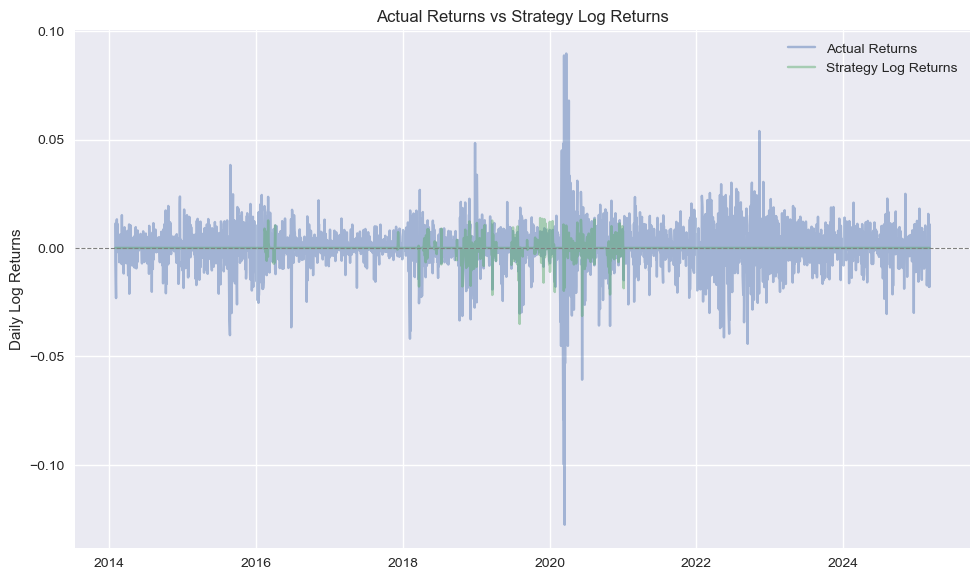

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(df_backtest.index, df_backtest['log_returns'], label="Actual Returns", alpha=0.45)
plt.plot(df_backtest.index, df_backtest['strat_log_ret'], label="Strategy Log Returns", alpha=0.45)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Actual Returns vs Strategy Log Returns")
plt.ylabel("Daily Log Returns")
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'returns_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Plot 2: Equity Curve of the Strategy
Show the cumulative performance over time.

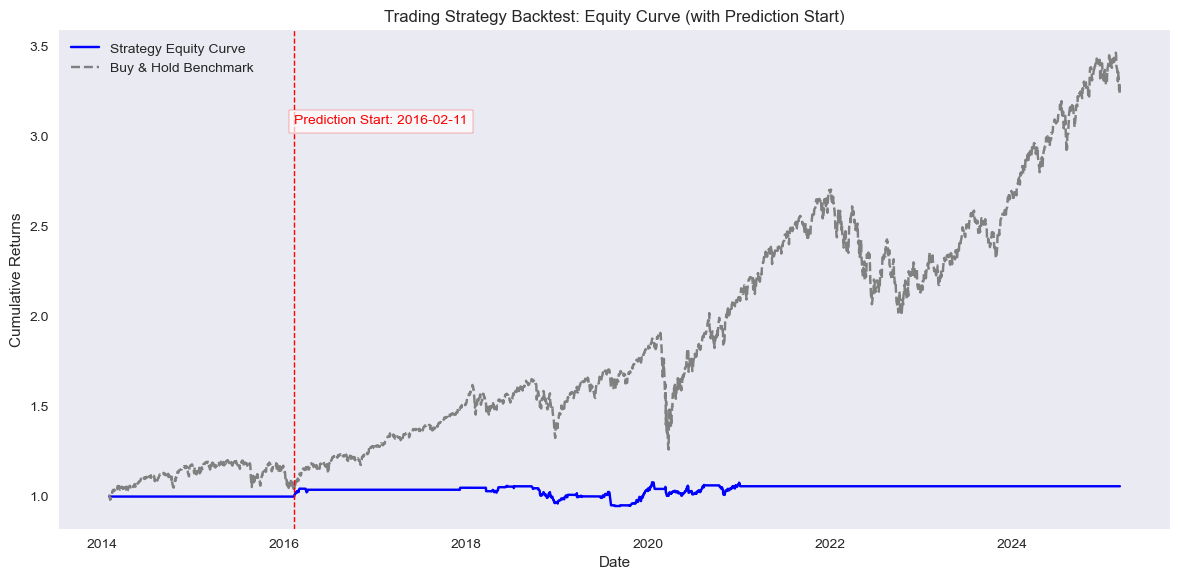

In [33]:
plt.figure(figsize=(12, 6))

# Strategy equity curve
plt.plot(df_backtest.index, df_backtest['strategy_equity'],
         label="Strategy Equity Curve", color='blue')

# Buy & Hold baseline
plt.plot(df_backtest.index, df_backtest['bh_equity'],
         label="Buy & Hold Benchmark", color='gray', linestyle="--")

# Mark prediction start
pred_start = df_backtest['p'].first_valid_index()
plt.axvline(pred_start, color='red', linestyle='--', linewidth=1)

# Horizontal annotation instead of vertical
plt.text(pred_start, 
         df_backtest['bh_equity'].max() * 0.9,  # place label near the top
         f"Prediction Start: {pred_start.date()}",
         rotation=0, color='red', ha='left', va='top', fontsize=10,
         bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))

plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Trading Strategy Backtest: Equity Curve (with Prediction Start)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'equity_curve_with_pred_start.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

## Plot 3: Strategy vs. Benchmark Comparison
Illustrate whether the strategy outperforms a simple buy-and-hold benchmark.

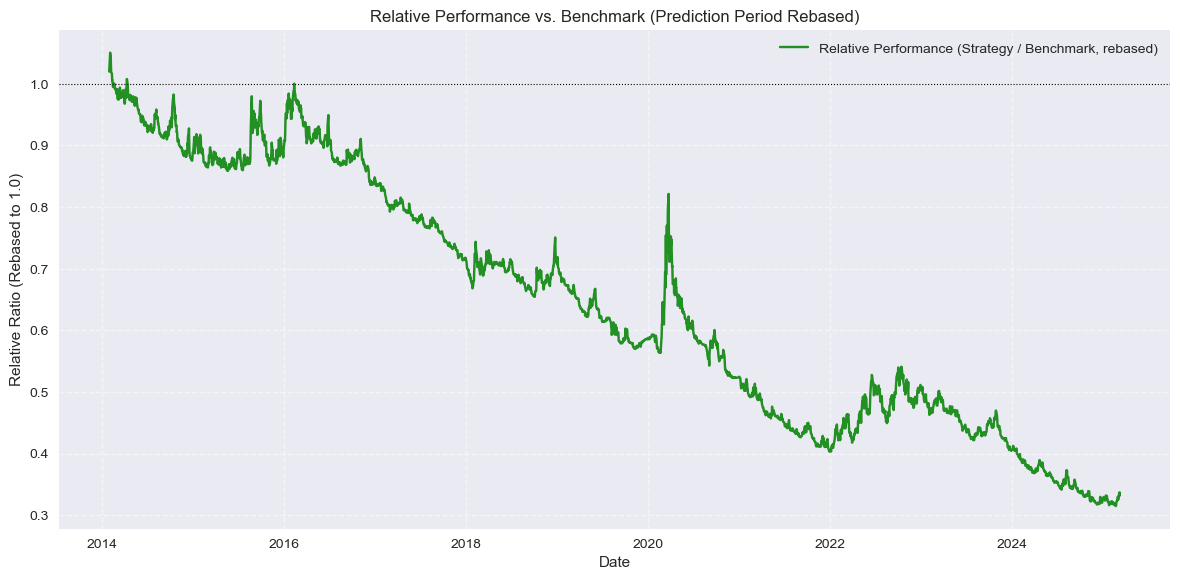

In [34]:
# ===========================================
# Relative Performance (Rebased at Prediction Start)
# ===========================================
plt.figure(figsize=(12, 6))

# Compute relative performance
df_backtest['relative_perf'] = df_backtest['strategy_equity'] / df_backtest['bh_equity']

# Rebase at 1.0 on the first prediction date
pred_start = df_backtest['p'].first_valid_index()
if pred_start is not None:
    base_value = df_backtest.loc[pred_start, 'relative_perf']
    df_backtest['relative_perf_rebased'] = df_backtest['relative_perf'] / base_value
else:
    df_backtest['relative_perf_rebased'] = df_backtest['relative_perf']

# Plot
plt.plot(df_backtest.index, df_backtest['relative_perf_rebased'],
         label="Relative Performance (Strategy / Benchmark, rebased)", 
         color="green", alpha=0.85)

plt.axhline(y=1.0, color='black', linestyle=':', linewidth=0.8)
plt.title("Relative Performance vs. Benchmark (Prediction Period Rebased)")
plt.ylabel("Relative Ratio (Rebased to 1.0)")
plt.xlabel("Date")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'relative_performance_rebased.png', dpi=300, bbox_inches='tight')

plt.show()
plt.close()


## `quantstats` Analytics Module

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2016-02-11   2016-02-11
End Period          2025-03-07   2025-03-07
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       19.0%

Cumulative Return   211.59%      5.72%
CAGR﹪              9.03%        0.42%

Sharpe              0.79         0.17
Prob. Sharpe Ratio  99.02%       68.94%
Sortino             1.1          0.22
Sortino/√2          0.78         0.15
Omega               1.07         1.07

Max Drawdown        -33.92%      -10.6%
Longest DD Days     745          1873

Gain/Pain Ratio     0.17         0.07
Gain/Pain (1M)      0.97         0.22

Payoff Ratio        0.81         0.91
Profit Factor       1.17         1.07
Common Sense Ratio  1.08         1.56
CPC Index           0.51         0.5
Tail Ratio          0.93         1.45
Outlier Win Ratio   2.52         40.07
Outlier Loss Ratio  2.83         5.05

MTD                 -3.1%        0.0%
3M              

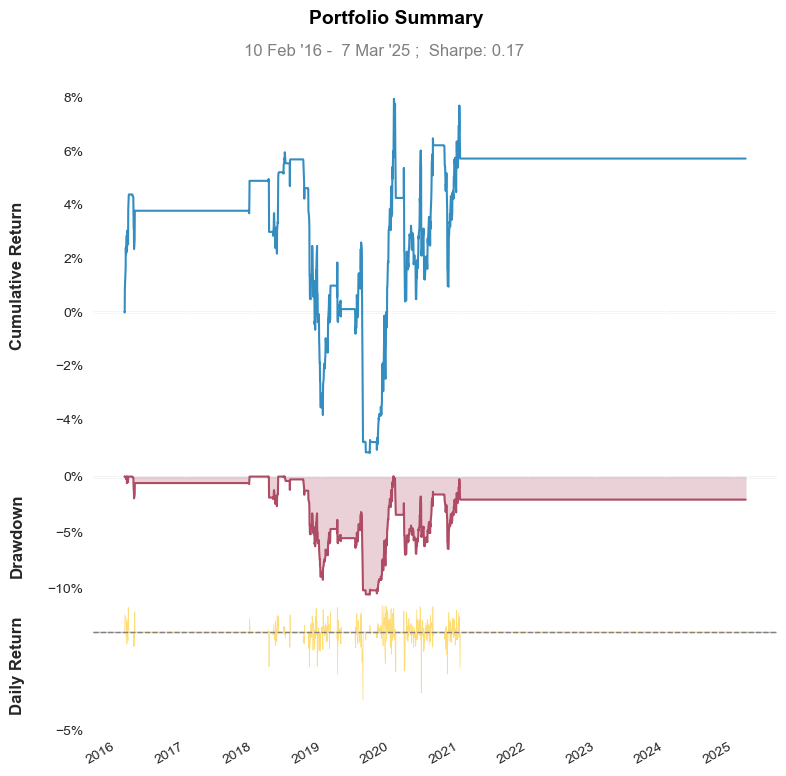

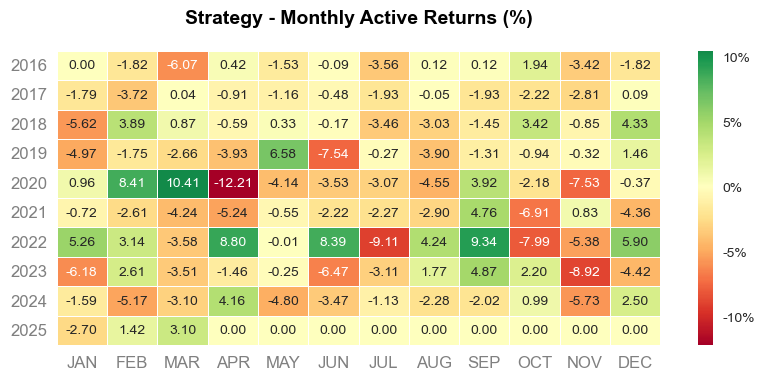

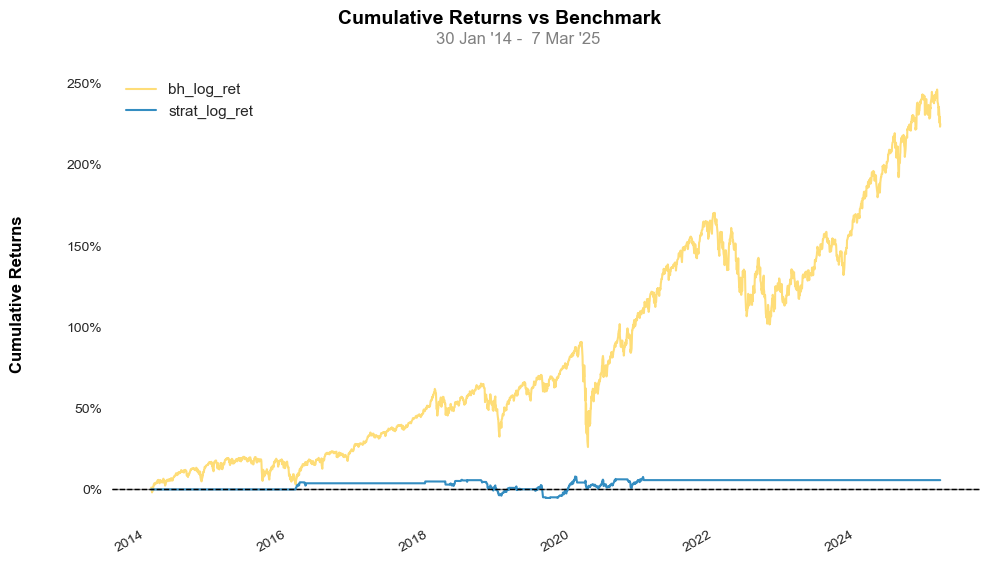

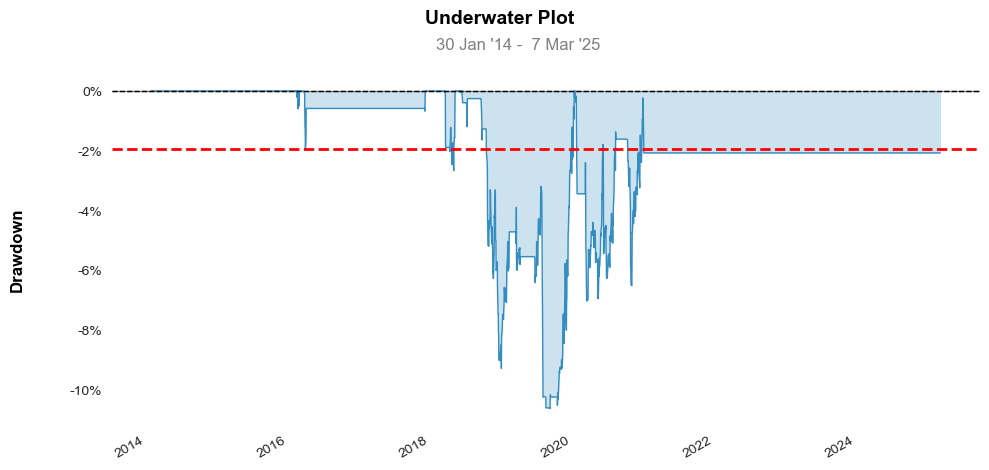

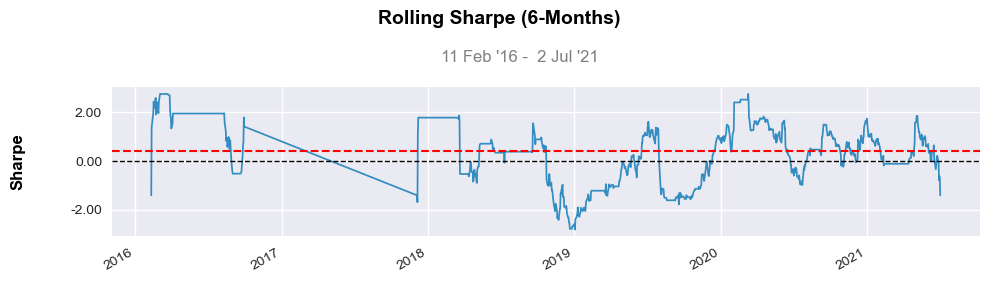

In [35]:
# Convert log returns to simple daily returns
strategy_simple_returns = np.exp(df_backtest['strat_log_ret']) - 1
benchmark_simple_returns = np.exp(df_backtest['bh_log_ret']) - 1

# Generate a Performance Report
qs.reports.basic(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Cumulative Returns Comparison (Strategy vs. Benchmark)
qs.plots.returns(strategy_simple_returns, benchmark=benchmark_simple_returns)

# Drawdown Analysis
qs.plots.drawdown(strategy_simple_returns)

# Rolling Sharpe Ratio
qs.plots.rolling_sharpe(strategy_simple_returns)

In [36]:
# === Export Clean CNN-LSTM Model Results (Fixed) ===
df_cnn_lstm = df_backtest[['log_returns', 'p', 'strat_log_ret']].copy()
df_cnn_lstm.rename(columns={
    'p': 'predictions',
    'strat_log_ret': 'strategy_log_return'  # alias to keep downstream code happy
}, inplace=True)

# Drop rows with missing predictions (common in time series)
df_cnn_lstm.dropna(subset=['predictions'], inplace=True)

# Confirm structure
print(df_cnn_lstm.head())
print(df_cnn_lstm.shape)

df_cnn_lstm.to_csv(OUTPUT_DIR / 'df_att_lstm.csv', index=False)

            log_returns  predictions  strategy_log_return
Date                                                     
2016-02-11    -0.012377     0.644734            -0.000230
2016-02-12     0.019330     0.648298             0.008906
2016-02-16     0.016382     0.644447             0.007432
2016-02-17     0.016346     0.646955             0.007589
2016-02-18    -0.004677     0.643468            -0.002106
(1344, 3)


## Diagnostics & Treshold Analysis

Mean predicted prob: 0.53125966
Min/Max predicted prob: 0.4433707 0.6482976
Positive ratio train/test: 0.536 0.552
Optimal threshold by F1: 0.400, F1=0.711
Fixed threshold 0.50 gave F1=0.671
Best threshold by Sharpe: 0.400, Sharpe=0.146


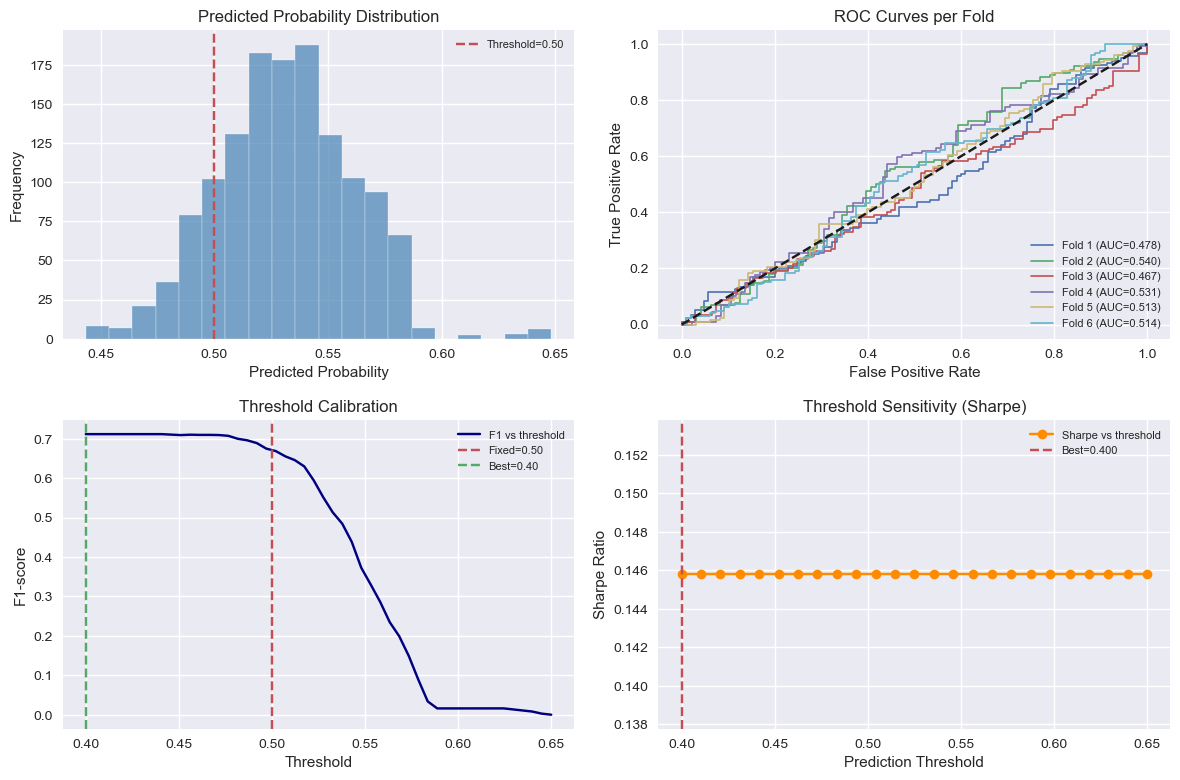

In [37]:
# ============================================
# Consolidated Diagnostics & Interpretation
# ============================================
from sklearn.metrics import f1_score

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# --- 1. Predicted Probability Distribution ---
axes[0,0].hist(pred, bins=20, alpha=0.7, color="steelblue")
axes[0,0].axvline(PRED_THRESHOLD, color='r', linestyle='--', label=f"Threshold={PRED_THRESHOLD:.2f}")
axes[0,0].set_title("Predicted Probability Distribution")
axes[0,0].set_xlabel("Predicted Probability"); axes[0,0].set_ylabel("Frequency")
axes[0,0].legend(fontsize=8)

print("Mean predicted prob:", pred.mean())
print("Min/Max predicted prob:", pred.min(), pred.max())
print("Positive ratio train/test:",
      round(train_sequence_labels.mean(), 3), round(true_labels.mean(), 3))

# --- 2. ROC Curves per Fold + AUC ---
for entry in roc_curves:
    axes[0,1].plot(entry["fpr"], entry["tpr"], lw=1.2,
                   label=f'Fold {entry["fold"] + 1} (AUC={entry["auc"]:.3f})')
axes[0,1].plot([0,1],[0,1],'k--')
axes[0,1].set_xlabel("False Positive Rate"); axes[0,1].set_ylabel("True Positive Rate")
axes[0,1].set_title("ROC Curves per Fold")
axes[0,1].legend(fontsize=8, loc="lower right")

# --- 3. Threshold Calibration (F1 vs Threshold) ---
f1_thresholds = np.linspace(0.40, 0.65, 50)
f1_scores = [f1_score(true_labels, (predictions >= t).astype(int), zero_division=0)
             for t in f1_thresholds]
best_t = f1_thresholds[np.argmax(f1_scores)]

axes[1,0].plot(f1_thresholds, f1_scores, label="F1 vs threshold", color="navy")
axes[1,0].axvline(PRED_THRESHOLD, color='r', ls='--', label=f"Fixed={PRED_THRESHOLD:.2f}")
axes[1,0].axvline(best_t, color='g', ls='--', label=f"Best={best_t:.2f}")
axes[1,0].set_xlabel("Threshold"); axes[1,0].set_ylabel("F1-score")
axes[1,0].set_title("Threshold Calibration")
axes[1,0].legend(fontsize=8)

print(f"Optimal threshold by F1: {best_t:.3f}, F1={max(f1_scores):.3f}")
print(f"Fixed threshold {PRED_THRESHOLD:.2f} gave F1="
      f"{f1_score(true_labels, (predictions >= PRED_THRESHOLD).astype(int), zero_division=0):.3f}")

# --- 4. Sharpe vs Threshold ---
import contextlib, io
def run_bt_with_threshold(th):
    f = io.StringIO()
    with contextlib.redirect_stdout(f):  # silence prints
        df_bt, bt_summary = run_backtest_clean(df, predictions, pred_index=pred_index)
    return bt_summary.get("sharpe", np.nan)

sharpe_thresholds = np.linspace(0.40, 0.65, 25)
results = [(th, run_bt_with_threshold(th)) for th in sharpe_thresholds]
best_th, best_sharpe = max(results, key=lambda x: x[1])

axes[1,1].plot(*zip(*results), 'o-', label="Sharpe vs threshold", color="darkorange")
axes[1,1].axvline(best_th, color='r', ls='--', label=f"Best={best_th:.3f}")
axes[1,1].set_xlabel("Prediction Threshold"); axes[1,1].set_ylabel("Sharpe Ratio")
axes[1,1].set_title("Threshold Sensitivity (Sharpe)")
axes[1,1].legend(fontsize=8)

print(f"Best threshold by Sharpe: {best_th:.3f}, Sharpe={best_sharpe:.3f}")

plt.tight_layout()
plt.show()


In [38]:
# =========================================
# ATT-LSTM Pipeline State Check (v3 recap)
# =========================================
import os
from datetime import datetime

def check_file(path):
    """Return status, size, and last modified if file exists."""
    if path.exists():
        size = os.path.getsize(path) / 1024  # KB
        mtime = datetime.fromtimestamp(path.stat().st_mtime).strftime('%Y-%m-%d %H:%M:%S')
        return True, f"✅ ({size:.1f} KB, {mtime})"
    else:
        return False, "✗"

print("=== ATT-LSTM Pipeline State Check ===\n")

# Track missing flags
missing_cv, missing_backtest, missing_stageA, missing_final = False, False, False, False

# --- CV artifacts ---
print("[CV]")
for fname in ["predictions.npy", "true_labels.npy", "pred_index.npy", "fold_metrics.csv"]:
    exists, msg = check_file(OUTPUT_DIR / fname)
    if not exists: missing_cv = True
    print(f"- {fname}: {msg}")

# --- Backtest summaries ---
print("\n[Backtest]")
for fname in ["backtest_summary.json", "backtest_summary.csv"]:
    exists, msg = check_file(OUTPUT_DIR / fname)
    if not exists: missing_backtest = True
    print(f"- {fname}: {msg}")

# --- Threshold Calibration Stage A ---
print("\n[Stage A]")
for fname in ["threshold_sweep.csv", "threshold_sweep.png"]:
    exists, msg = check_file(OUTPUT_DIR / fname)
    if not exists: missing_stageA = True
    print(f"- {fname}: {msg}")

# --- Plots ---
print("\n[Plots]")
for fname in [
    "equity_curve_strategy.png", 
    "relative_performance.png", 
    "roc_curve.png", 
    "pr_curve.png",
]:
    exists, msg = check_file(OUTPUT_DIR / fname)
    print(f"- {fname}: {msg}")

attn_dir = OUTPUT_DIR / "attn_plots"
if attn_dir.exists():
    for fname in ["attn_summary_heatmap.png", "attn_summary_mean.png"]:
        exists, msg = check_file(attn_dir / fname)
        print(f"- attn_plots/{fname}: {msg}")
else:
    print("- attn_plots/: ✗ (folder missing)")

# --- Final summaries ---
print("\n[Final Summary]")
for fname in ["final_summary.json", "final_summary.md"]:
    exists, msg = check_file(OUTPUT_DIR / fname)
    if not exists: missing_final = True
    print(f"- {fname}: {msg}")

# --- Overall verdict ---
print("\n=== State check complete ===")
if missing_cv or missing_backtest:
    print("⚠️ Critical artifacts missing — rerun CV training and/or backtest before Stage A or Final Summary.")
elif missing_stageA:
    print("ℹ️ Core pipeline is ready, but Stage A sweep has not yet been run.")
elif missing_final:
    print("ℹ️ Pipeline complete, but Final Summary exports are missing.")
else:
    print("✅ All artifacts present — pipeline is fully up to date.")


=== ATT-LSTM Pipeline State Check ===

[CV]
- predictions.npy: ✅ (5.4 KB, 2025-09-25 18:28:40)
- true_labels.npy: ✅ (10.6 KB, 2025-09-25 18:28:40)
- pred_index.npy: ✅ (10.6 KB, 2025-09-25 18:28:40)
- fold_metrics.csv: ✅ (0.5 KB, 2025-09-25 18:28:40)

[Backtest]
- backtest_summary.json: ✅ (0.7 KB, 2025-09-25 18:28:42)
- backtest_summary.csv: ✅ (0.5 KB, 2025-09-25 18:28:42)

[Stage A]
- threshold_sweep.csv: ✅ (1.2 KB, 2025-09-25 18:28:41)
- threshold_sweep.png: ✅ (129.5 KB, 2025-09-25 18:28:42)

[Plots]
- equity_curve_strategy.png: ✅ (262.6 KB, 2025-09-25 17:04:04)
- relative_performance.png: ✅ (254.7 KB, 2025-09-25 17:08:12)
- roc_curve.png: ✅ (192.4 KB, 2025-09-25 17:17:33)
- pr_curve.png: ✅ (95.3 KB, 2025-09-25 17:17:33)
- attn_plots/attn_summary_heatmap.png: ✅ (40.6 KB, 2025-09-25 18:28:40)
- attn_plots/attn_summary_mean.png: ✅ (43.1 KB, 2025-09-25 18:28:40)

[Final Summary]
- final_summary.json: ✅ (0.7 KB, 2025-09-25 17:20:42)
- final_summary.md: ✅ (0.6 KB, 2025-09-25 17:20:42)

===